In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers, models, datasets, backend
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

with tf.device("/gpu:0"):
    np.random.seed(3)
    tf.random.set_seed(3)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
tf.__version__

'2.7.0'

In [4]:
x_train = train.drop('label', axis=1, inplace=False)
y_train = train['label']

In [5]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
y_train = y_train.values.reshape(-1, 1)

In [6]:
x_test = test
x_test = x_test.values.reshape(-1, 28, 28, 1)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

[0]


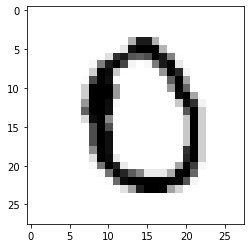

In [8]:
plt.imshow(x_train[5], cmap='Greys', interpolation='None')
print(y_train[5])

In [9]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0


In [10]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)


In [11]:
y_train[5]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        51232     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [14]:
batch_size = 100
epochs = 100

In [15]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1
)

In [16]:
model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
)

In [17]:
callbacks = [EarlyStopping(monitor='accuracy', patience=3)]
history = model.fit(
                train_datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=100,
                epochs=epochs,
                validation_data=(x_val, y_val),
                verbose=1,
                callbacks=callbacks
                )

Epoch 1/100
100/100 [==============================] - 23s 221ms/step - loss: 0.7311 - accuracy: 0.7556 - val_loss: 0.1155 - val_accuracy: 0.9636
Epoch 2/100
100/100 [==============================] - 21s 212ms/step - loss: 0.2088 - accuracy: 0.9341 - val_loss: 0.1016 - val_accuracy: 0.9700
Epoch 3/100
100/100 [==============================] - 20s 196ms/step - loss: 0.1560 - accuracy: 0.9533 - val_loss: 0.0909 - val_accuracy: 0.9752
Epoch 4/100
100/100 [==============================] - 18s 183ms/step - loss: 0.1227 - accuracy: 0.9627 - val_loss: 0.0682 - val_accuracy: 0.9783
Epoch 5/100
100/100 [==============================] - 18s 185ms/step - loss: 0.1164 - accuracy: 0.9656 - val_loss: 0.0723 - val_accuracy: 0.9757
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 0.0973 - accuracy: 0.9680 - val_loss: 0.0643 - val_accuracy: 0.9783
Epoch 7/100
100/100 [==============================] - 18s 184ms/step - loss: 0.0924 - accuracy: 0.9714 - val_loss: 0.0641 -

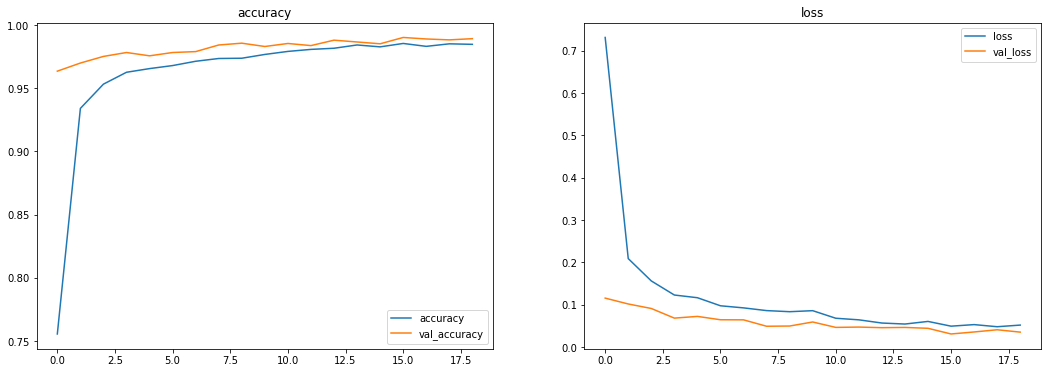

In [18]:
plt.figure(figsize=(18, 6))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("accuracy")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("loss")
plt.legend()

plt.show()

In [19]:
result = model.predict(x_test)

In [20]:
result = np.argmax(result,axis=1)

In [21]:
result

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [22]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Label'] = result
submission.to_csv('final_submission.csv', index=False)